In [1]:
import numpy as np
from PIL import Image
import cv2

In [2]:
image = np.array(Image.open('data/marker_cut_rgb_512.png'))

In [3]:
edge_kernel = np.array([[0, 1, 0],
                        [1, -4, 1],
                        [0, 1, 0]]).astype(float)

edge_kernel_changed = np.array([[-1, -1, -1],
                                [-1, 8, -1],
                                [-1, -1, -1]]).astype(float)

smooth_kernel = np.ones((5, 5)) / 25.0

In [4]:
def to_grayscale(image):
    
    gray = 0.2989 * image[:, :, 0] + 0.5870 * image[:, :, 1] + 0.1140 * image[:, :, 2]

    return gray.astype(np.uint8)

def convolution(image, kernel):
    '''Vanilla implementation of convolution'''
    image_shape = np.array(image.shape)
    kernel_shape = np.array(kernel.shape)
    
    height, width = image_shape - kernel_shape + 1
    
    output = np.zeros((height, width))
    
    for i in range(height):
        for j in range(width): 
            
            output[i][j] = np.sum(image[i:i+kernel_shape[0], j:j+kernel_shape[1]] * kernel)
            
    return output

def normalization(image):
    '''Image normalization to range 0 ... 255'''
    image = image + np.abs(image.min())
    image = image / image.max()
    image = image * 255
    image = image.astype(np.uint8)
    
    return image

In [11]:
output = convolution(to_grayscale(image), smooth_kernel)
output = convolution(output, edge_kernel_changed)

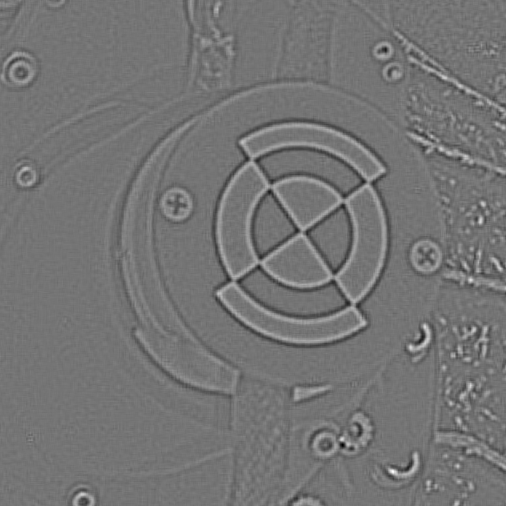

In [12]:
x = normalization(output)
Image.fromarray(x)

In [33]:
# use threshold as quantile of the discribution of pixels
x = (x > np.quantile(x, 0.95)).astype(np.uint8) * 255

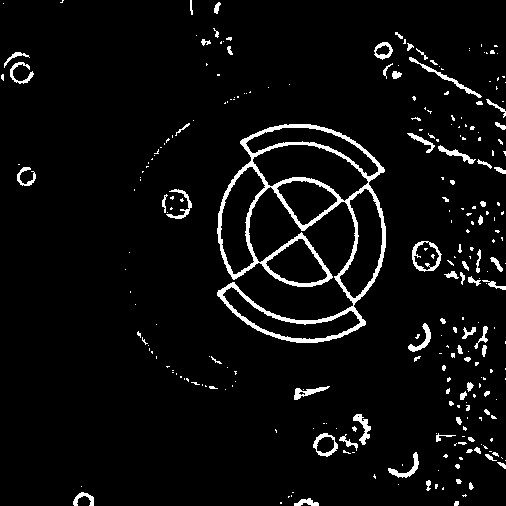

In [34]:
Image.fromarray(x)

In [17]:
def hough_lines_acc(image, rho_resolution=1, theta_resolution=1):
    '''Compute Hough space accumulator and return also rhos and thetas parameters'''
    height, width = image.shape 
    diagonal = np.ceil(np.sqrt(height**2 + width**2)) 
    rhos = np.arange(-diagonal, diagonal+1, rho_resolution)
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))
    
    output_shape = (len(rhos), len(thetas))
    output = np.zeros(output_shape, dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(image) 
    for i in range(len(x_idxs)): 
        
        x = x_idxs[i]
        y = y_idxs[i]
        
        for j in range(len(thetas)): 
            rho = int((x * np.cos(thetas[j]) + y * np.sin(thetas[j])) + diagonal)
            output[rho, j] += 1
            
    return output, rhos, thetas

def peaks(image, rhos, thetas, n_peaks=2):
    '''Find peaks and return chosen parameters'''
    x_indexes, y_indexes = np.nonzero(image)
    peaks = list(map(lambda x: image[x[0]][x[1]], zip(x_indexes, y_indexes)))
    
    indexes_of_interest = np.argsort(np.array(peaks))[::-1][:n_peaks]
        
    output = []
    
    for i in indexes_of_interest:
        
        output.append((rhos[x_indexes[i]], thetas[y_indexes[i]]))
    
    return output

In [18]:
output, rhos, thetas = hough_lines_acc(x)

In [19]:
params = peaks(output, rhos, thetas)

In [20]:
def hough_lines_draw(img, params):
    '''Plot lines on the image'''
    for element in params:
        # reverse engineer lines from rhos and thetas
        rho, theta = element
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
    return img  

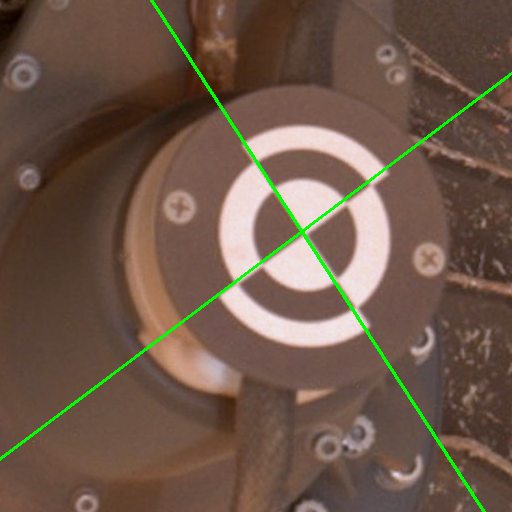

In [21]:
Image.fromarray(hough_lines_draw(image, params))

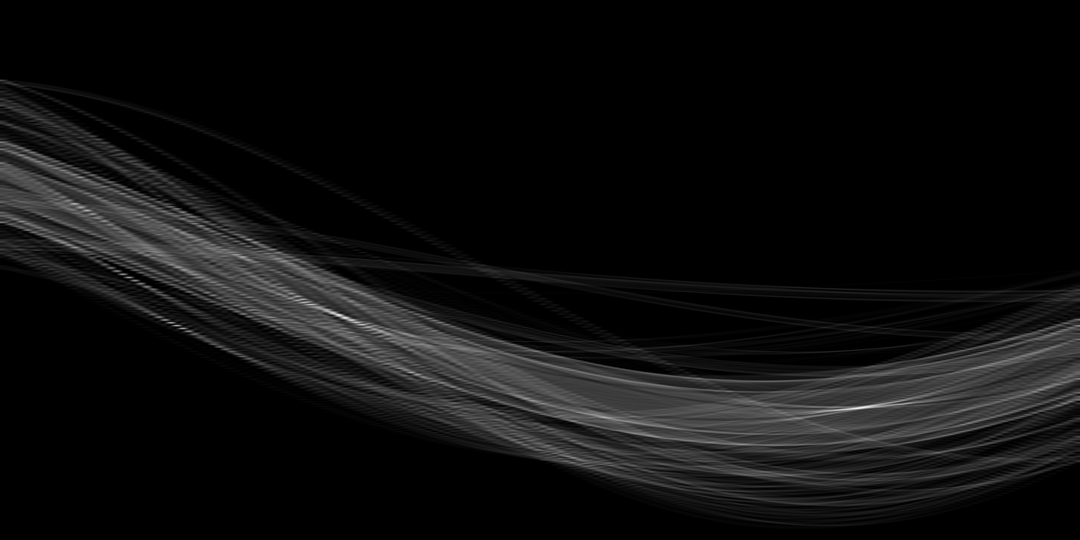

In [22]:
# Hough space visualization in the (rho, theta) space
Image.fromarray((output / output.max() * 255.0).astype(np.uint8)).resize((6*min(output.shape), 3*min(output.shape)), Image.ANTIALIAS)